In [1]:
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
draw_n_days = 400
df = hl.df_init(filename)

Current file path is /Users/kai/Desktop/qs/data_csv_distinct_0606/000002.SZ.csv


In [ ]:
# 完整测试
import horizontal_area as ha
import high_low_xuejie_zuhui as hl
filename = '000001.SZ.csv'
df = hl.df_init(filename)
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
result = ha.find_horizontal_area(df, high_points, low_points, fft_percentile=100, min_len_of_window=3, ignore_hl=False)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

In [ ]:
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=100, print_result=False, show_plot=True, save_plot=False)

In [ ]:
# 对上方得到的data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
data.plot(x='TRADE_DT', y='S_DQ_CLOSE', figsize=(20, 10))
# 对data进行DFT变换
data_fft = fft(data['S_DQ_CLOSE'].values)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_fft)
plt.show()
# 计算频谱中的总能量，并计算高频成分所占的比例。如果高频成分所占比例较小，那么曲线就比较平滑。
# 计算频谱中的总能量
energy = (data_fft * np.conj(data_fft)).real
# 计算高频成分所占的比例
high_freq_ratio = np.sum(energy[10:]) / np.sum(energy)
print(high_freq_ratio)
# 对高频成分进行滤波
data_fft_filtered = data_fft.copy()
data_fft_filtered[15:] = 0
# 对滤波后的数据进行逆变换
data_filtered = ifft(data_fft_filtered)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(data_filtered)
plt.show()

In [ ]:
# 对data曲线进行DFT变换，得到频域上的信号
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
import high_low_xuejie_zuhui as hl
filename = '000002.SZ.csv'
df = hl.df_init(filename)
data = df.tail(200)
# 将data等分为20份，对每份按照上述方法求的高频成分所占比例
n = 20
data_list = np.array_split(data, n)
high_freq_ratio_list = []
for temp_data in data_list:
    data_fft = fft(temp_data['S_DQ_CLOSE'].values)
    energy = (data_fft * np.conj(data_fft)).real
    high_freq_ratio = np.sum(energy[3:]) / np.sum(energy)
    high_freq_ratio_list.append(high_freq_ratio)
# 可视化
plt.figure(figsize=(20, 10))
plt.plot(high_freq_ratio_list)
plt.show()
print(high_freq_ratio_list)
# 使用plt.axvspan将高频成分占比可视化到data曲线上，高频占比越高的区域颜色越深
plt.figure(figsize=(20, 10))
plt.plot(data['S_DQ_CLOSE'].values)
for i in range(len(high_freq_ratio_list)):
    plt.axvspan(i * 10, (i + 1) * 10, facecolor='r',
                alpha=high_freq_ratio_list[i] * 100)

---

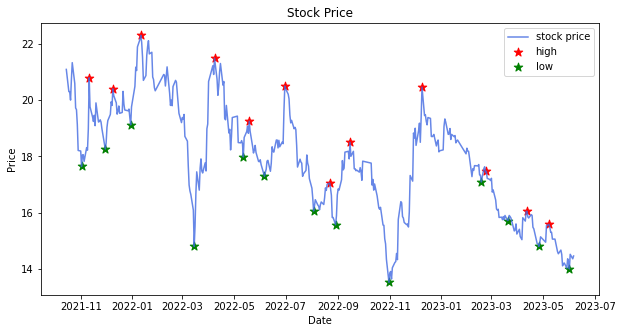

100%|██████████| 419/419 [00:01<00:00, 333.42it/s]


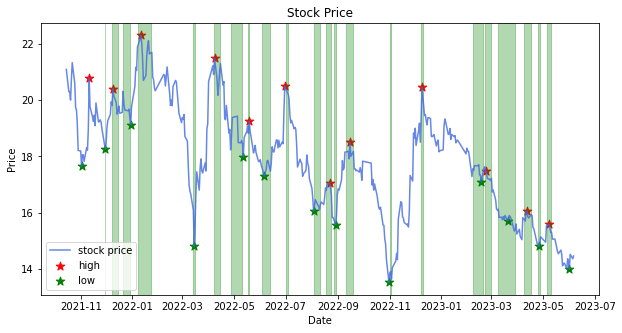

(419, 2587)

In [8]:
# hl median测试
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
result = ha.find_ha_near_hl_median(df, high_points, low_points, 0.03)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=400, print_result=False, show_plot=True, save_plot=False)

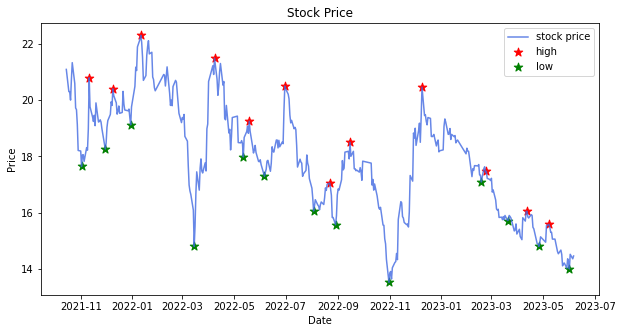

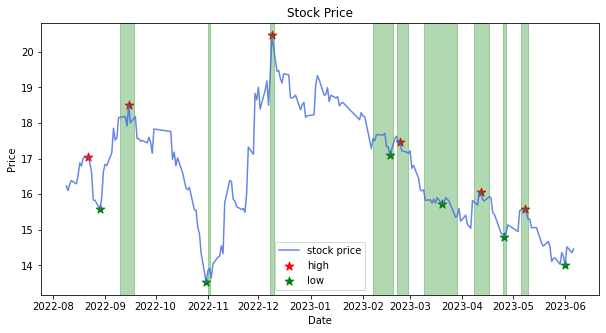

(419, 2587)

In [9]:
high_points, low_points = hl.find_high_low(df, filename, save_data=False, draw_n_days=400)
ha.draw_horizontal_area(df, result, high_points, low_points, filename, n_days=200, print_result=False, show_plot=True, save_plot=False)

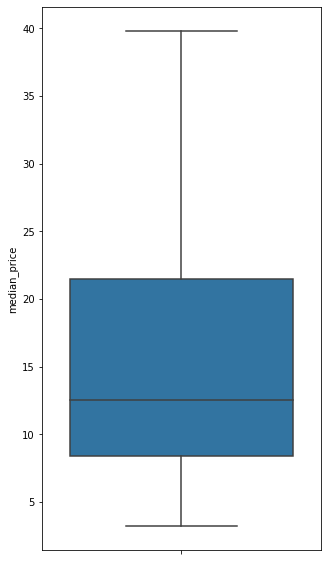

In [7]:
result
# 绘制result中位数的boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [5, 10]
sns.boxplot(y='median_price', data=result)
plt.show()



In [11]:
result.tail(10)

,start_date,end_date,interval,median_price
0,2022-08-27,2022-08-29,2,15.570
0,2022-09-10,2022-09-18,8,18.090
0,2022-11-01,2022-11-02,1,13.885
0,2022-12-10,2022-12-08,-2,NaN
0,2023-02-07,2023-02-19,12,17.560
0,2023-02-21,2023-02-28,7,17.325
0,2023-03-09,2023-03-29,20,15.810
0,2023-04-08,2023-04-17,9,15.890
0,2023-04-25,2023-04-27,2,14.880
0,2023-05-06,2023-05-10,4,15.470
